#Initialization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import cv2
import pickle
%matplotlib inline
import hypar
import backbone_0 as nn
import network_16 as net

#Helper Functions

In [3]:
def get_embeddings(input_imgs,model):
  test_model = model.resnet
  embeddings = test_model.predict(input_imgs)
  print(embeddings.shape)
  return embeddings

In [4]:
def get_distance(emb1,emb2):
  """
  emb1 & emb2: are both 512 dimensional vectors from the trained resnet model

  get_distance: returns dot_prod,cosine_distance,euclidean_distance
  Check Out "https://github.com/zestyoreo/Arcface/blob/main/get_distance()_test.ipynb" for clarity
  """
  dot_prod = np.dot(emb1,emb2.T)

  a = np.matmul(np.transpose(emb1), emb2)
  b = np.sum(np.multiply(emb1, emb1))
  c = np.sum(np.multiply(emb2, emb2))
  cosine_distance = 1 - (a / (np.sqrt(b) * np.sqrt(c)))

  euclidean_distance = emb1 - emb2
  euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
  euclidean_distance = np.sqrt(euclidean_distance)

  return dot_prod,cosine_distance,euclidean_distance

In [5]:
def calculate_threshold(X,Y,model,nor,epochs):
  index = [None] * X.shape[0]

  #getting and storing embeddings
  embeddings = get_embeddings(X,model)
  file_name = "threshold\ and\ distances/train_data_embeddings_"+str(epochs)+"model.npy"
  if nor==True:
    embeddings = normalize(embeddings, axis = 0)
    file_name = "threshold\ and\ distances/train_data_normalized_embeddings_"+str(epochs)+"model.npy"
  emb = np.array(embeddings)
  np.save(file_name,emb)

  same_person_distance = []
  same_person_cosine_distance = []
  same_person_euclidean_distance = []
  for clas in range(hypar.num_classes):
    index[clas] = []
    for i in range (0,X.shape[0]):
      if Y[i] == clas:
        index[clas].append(i)
    for i in range(len(index[clas])):
      i1=index[clas][i]
      for j in range(i+1,len(index[clas])):
        j2=index[clas][j]
        distance,cosine_distance,euclidean_distance = get_distance(embeddings[i1],embeddings[j2])
        same_person_distance.append(distance)
        same_person_cosine_distance.append(cosine_distance)
        same_person_euclidean_distance.append(euclidean_distance)

  same_person_distance = np.asarray(same_person_distance)
  same_person_cosine_distance = np.asarray(same_person_cosine_distance)
  same_person_euclidean_distance = np.asarray(same_person_euclidean_distance)

  #saving same person distances
  f1 = "threshold\ and\ distances/same_person_distance_"+str(epochs)+"model.npy"
  f2 = "threshold\ and\ distances/same_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "threshold\ and\ distances/same_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "threshold\ and\ distances/same_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "threshold\ and\ distances/same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "threshold\ and\ distances/same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,same_person_distance)
  np.save(f2,same_person_cosine_distance)
  np.save(f3,same_person_euclidean_distance)
  
  same_person_distance_mean = np.mean(same_person_distance)
  same_person_cosine_distance_mean = np.mean(same_person_cosine_distance)
  same_person_euclidean_distance_mean = np.mean(same_person_euclidean_distance)

  diff_person_distance = []
  diff_person_cosine_distance = []
  diff_person_euclidean_distance = []
  for clas in range(hypar.num_classes):
      for c in range(clas+1,hypar.num_classes):
          for i in range(len(index[clas])):
              for j in range(len(index[c])):
                  distance,cosine_distance,euclidean_distance = get_distance(embeddings[index[clas][i]],embeddings[index[c][j]])
                  diff_person_distance.append(distance)
                  diff_person_cosine_distance.append(cosine_distance)

                  diff_person_euclidean_distance.append(euclidean_distance)

  diff_person_distance = np.asarray(diff_person_distance)
  diff_person_cosine_distance = np.asarray(diff_person_cosine_distance)
  diff_person_euclidean_distance = np.asarray(diff_person_euclidean_distance)

  #saving different person distances
  f1 = "threshold\ and\ distances/diff_person_distance_"+str(epochs)+"model.npy"
  f2 = "threshold\ and\ distances/diff_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "threshold\ and\ distances/diff_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "threshold\ and\ distances/diff_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "threshold\ and\ distances/diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "threshold\ and\ distances/diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,diff_person_distance)
  np.save(f2,diff_person_cosine_distance)
  np.save(f3,diff_person_euclidean_distance)

  diff_person_distance_mean = np.mean(diff_person_distance)
  diff_person_cosine_distance_mean = np.mean(diff_person_cosine_distance)
  diff_person_euclidean_distance_mean = np.mean(diff_person_euclidean_distance)

  alpha=0.8
  distance_threshold = diff_person_distance_mean*(1-alpha)+same_person_distance_mean*alpha
  cosine_distance_threshold = diff_person_cosine_distance_mean*(1-alpha)+same_person_cosine_distance_mean*alpha
  euclidean_distance_threshold = diff_person_euclidean_distance_mean*(1-alpha)+same_person_euclidean_distance_mean*alpha
  return distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean

In [6]:
def recognise(img,face_imgs_database,face_embedding_database,face_names_database):
  """
  img: numpy array of dims (112,112,3) of image of face to be recognised
  face_imgs_database: numpy array of dims (num_of_faces,512)
  face_names_database: dictionary of form {index_of_face:"name_of_person"} comprising of names of faces in face_imgs_database array
    
  recognise: returns the name and face of the closest match in the database
  """
  img_embedding = get_embeddings(img)
  best_match_index = []
  best_distance = float('-inf')
  for i in range(int(face_embedding_database.shape[0])):
    distance,cosine_distance,euclidean_distance = get_distance(img_embedding,face_embedding_database[i])
    if distance>best_distance:
      best_distance = distance
      best_match_index = [i]
    elif distance==best_distance:
      best_match_index.append(i)

  names = []
  faces = []
  for i in best_match_index:
    names.append(face_names_database[i])
    faces.append(face_imgs_database[i])
    
  return names,faces

In [7]:
def verify(img,face):
  """
  img: numpy array of dims (112,112,3) of image of face to be verified
  face: image of face of person to be verified with
    
  verify: returns boolean if the faces match or not
  """
  img_embedding = get_embeddings(img)
  face_embedding = get_embeddings(face)
  distance,cosine_distance,euclidean_distance = get_distance(img_embedding,face_embedding)
  if distance>threshold:
    return True
  return False

#Importing Train data

In [9]:
X = np.load('datasets/x_train.npy', allow_pickle=True)
Y = np.load('datasets/y_train.npy', allow_pickle=True)
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='int32')
Y = np.reshape(Y, Y.shape[0])
print("X shape:",X.shape,"Y shape:",Y.shape)
X = net.Resnet_preprocess(X)
print("Training data ready!")

X shape: (1476, 112, 112, 3) Y shape: (1476,)
Training data ready!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


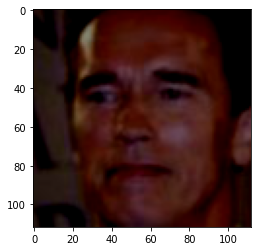

In [11]:
index = 139 # change index to view different image/person
photo = cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB)
plt.imshow(photo/255)
plt.show()

#Distance Plots

In [42]:
d_threshold= []
cd_threshold = []
ed_threshold = []
d_norm_threshold= []
cd_norm_threshold = []
ed_norm_threshold = []
for file_number in [800]:
  #loading model
  file_name = 'models/model_weights_'
  file_name = file_name + str(file_number)+ '_epochs'
  print(file_name)
  model = tf.keras.models.load_model(file_name)

  #non-normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = calculate_threshold(X,Y,model,False,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_threshold.append(distance_threshold)
  cd_threshold.append(cosine_distance_threshold)
  ed_threshold.append(euclidean_distance_threshold)

  #normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = calculate_threshold(X,Y,model,True,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_norm_threshold.append(distance_threshold)
  cd_norm_threshold.append(cosine_distance_threshold)
  ed_norm_threshold.append(euclidean_distance_threshold)

/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_300_epochs
(1476, 512)
10891995.293750001 0.20158817674184765 657.1789916992187 13615643.0 0.0003950489919425283 576.5906 -2595.5312 1.0063606877414684 979.53265
(1476, 512)
1.3521550080447924 0.20147887157777183 0.27406898736953733 1.6902989 0.0004083976552116914 0.22754401 -0.0004206194 1.0057607672680127 0.4601689
/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_550_epochs
(1476, 512)
3738330.3488403326 0.2013977791572457 381.5714965820312 4673140.5 4.9238332470749186e-05 329.7935 -910.2558 1.0067919424563456 588.68353
(1476, 512)
1.3405931123066694 0.20128138111748645 0.2715644478797913 1.6758628 8.182810913039208e-05 0.22263972 -0.00048559508 1.0060795931509108 0.46726334
/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_800_epochs
(1476, 512)
4779097.0437988285 0.20139404120057536 423.8443237304688 5974137.5 2.023268356164696e-05 368.54517 -1064.781 1.0068892752686305 645.04095
(1476, 512)
1.35589

In [13]:
model.summary()

Model: "train_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 16)                40375696  
                                                                 
 arcface__layer_1 (Arcface_L  multiple                 5232      
 ayer)                                                           
                                                                 
Total params: 40,380,928
Trainable params: 40,326,784
Non-trainable params: 54,144
_________________________________________________________________


In [14]:
test_model = model.resnet

In [15]:
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
Total params: 40,375,696
Trainable params: 40,321,552
Non-trainable params: 54,144
_____________________________________

In [ ]:
epochs = 800

#loading data
f1 = "threshold\ and\ distances/same_person_distance_"+str(epochs)+"model.npy"
f2 = "threshold\ and\ distances/same_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "threshold\ and\ distances/same_person_euclidean_distance_"+str(epochs)+"model.npy"

same_person_distance = np.load(f1)
same_person_cosine_distance = np.load(f2)
same_person_euclidean_distance = np.load(f3)

f1 = "threshold\ and\ distances/same_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "threshold\ and\ distances/same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "threshold\ and\ distances/same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

same_person_norm_distance = np.load(f1)
same_person_norm_cosine_distance = np.load(f2)
same_person_norm_euclidean_distance = np.load(f3)

f1 = "threshold\ and\ distances/diff_person_distance_"+str(epochs)+"model.npy"
f2 = "threshold\ and\ distances/diff_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "threshold\ and\ distances/diff_person_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_distance = np.load(f1)
diff_person_cosine_distance = np.load(f2)
diff_person_euclidean_distance = np.load(f3)

f1 = "threshold\ and\ distances/diff_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "threshold\ and\ distances/diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "threshold\ and\ distances/diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_norm_distance = np.load(f1)
diff_person_norm_cosine_distance = np.load(f2)
diff_person_norm_euclidean_distance = np.load(f3)

#_____Creating scatter plots (same vs diff)_______
def scatter_plot(same,diff,title,color1,color2):
  plt.figure(figsize = (8,8))
  al = np.ones((len(same)))
  al2 = np.ones((len(diff)))
  plt.scatter(al, same, color=color1, marker="*")
  plt.scatter(2*al2, diff, color=color2, marker=".")
  plt.xlabel("Distance")
  plt.ylabel("Distance")
  plt.legend(["same","diff"])
  plt.title(title)
  plt.show()

#distance data
scatter_plot(same_person_distance, diff_person_distance, "Same vs Diff People: Distance Scatterplot", "blue", "red")

#normailzed distance data
scatter_plot(same_person_norm_distance,diff_person_norm_distance,"Same vs Diff People: Normalized Distance Scatterplot", "deepskyblue", "hotpink")

#cosine distance data
scatter_plot(same_person_cosine_distance, diff_person_cosine_distance, "Same vs Diff People: Cosine Distance Scatterplot", "green", "indigo")

#cosine normailzed distance data
scatter_plot(same_person_norm_cosine_distance, diff_person_norm_cosine_distance, "Same vs Diff People: Normalized Cosine Distance Scatterplot", "springgreen", "violet")

#euclidean distance data
scatter_plot(same_person_euclidean_distance, diff_person_euclidean_distance, "Same vs Diff People: Euclidean Distance Scatterplot", "blue", "red")

#euclidean normailzed distance data
scatter_plot(same_person_norm_euclidean_distance, diff_person_norm_euclidean_distance, "Same vs Diff People: Normalized Euclidean Distance Scatterplot", "deepskyblue", "hotpink")

#Embedding PCA Plots

In [ ]:
#getting embedding from stored file
epochs = 800
num_f = 512
file_name = "threshold\ and\ distances/train_data_embeddings_"+str(epochs)+"model.npy"
norm_file_name = "threshold\ and\ distances/train_data_normalized_embeddings_"+str(epochs)+"model.npy"
embeddings = np.load(file_name)
norm_embeddings = np.load(norm_file_name)  

pca = PCA(n_components=2)

#getting image data, embeddings and normalized embeddings of 4 people
index = [None] * hypar.num_classes
ppl = [0,25,66,138]

for clas in ppl:
  index[clas] = []
  for i in range (0,X.shape[0]):
    if Y[i] == clas:
      index[clas].append(i)

ppl_emb = np.array(embeddings[index[ppl[0]][0]])
ppl_emb = np.reshape(ppl_emb,(1,num_f))
ppl_norm_emb = np.array(norm_embeddings[index[ppl[0]][0]])
ppl_norm_emb = np.reshape(ppl_norm_emb,(1,num_f))
ppl_targ = [ppl[0]]
print(ppl_emb.shape, ppl_norm_emb.shape)
for clas in ppl:
  l = []
  if clas==0:
    l = list(range(1,len(index[clas])-1))
  else:
    l = list(range(len(index[clas])))
  for i in l:
    j = index[clas][i]
    ppl_targ.append(clas)
    em = np.reshape(embeddings[j],(1,num_f))
    norm_em = np.reshape(norm_embeddings[j],(1,num_f))
    ppl_emb = np.concatenate((ppl_emb,em),axis=0)
    ppl_norm_emb = np.concatenate((ppl_norm_emb,norm_em),axis=0)

df = pd.DataFrame(ppl_targ,columns=["person"])
print(ppl_emb.shape, ppl_norm_emb.shape)


#embeddings PCA
principalComponents = pca.fit_transform(ppl_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title(str(epochs)+' Epoch:_16 Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#norm embeddings PCA
principalComponents = pca.fit_transform(ppl_norm_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title(str(epochs)+' Epoch:_16 Norm Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()